In [2]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

things that still need to be done:
    - add filepaths and location names for the remaining locations when they finish
    - stratify by age group if time
    - stratify by malnourishment if time

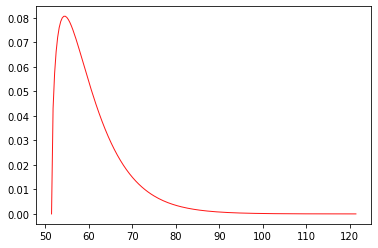

In [3]:
# distribution for the cost of BEP
loc = 51.42
mean = 60.42 - loc
a = 1.5
scale = mean/a
fig, ax = plt.subplots(1,1)
x = np.linspace(loc, loc+(120-50), 200)
ax.plot(x, scipy.stats.gamma.pdf(x, a, loc, scale), 'r-', lw=1, alpha=0.9, label='beta pdf')
plt.show()

In [5]:
output_dirs = ['/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/india/2020_02_06_17_37_48/count_data/',
                '/ihme/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/pakistan/2020_02_06_17_38_45/count_data/',
              '/share/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/tanzania/2020_02_06_17_39_16/count_data/',
              '/share/costeffectiveness/results/vivarium_gates_bep/scenarios_fixed/mali/2020_02_06_17_38_33/count_data/']

locations = ['India',
            'Pakistan',
            'Tanzania',
            'Mali']

In [24]:
#DALYs

master_avg = pd.DataFrame()
master_draws = pd.DataFrame()
master_counts = pd.DataFrame()

for i in list(range(0,4)):
    ylls = pd.read_hdf(output_dirs[i] + 'ylls.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylls'})
    ylds = pd.read_hdf(output_dirs[i] + 'ylds.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylds'})
    dalys = ylls.merge(ylds, right_on=['input_draw','scenario'], left_on=['input_draw','scenario'])
    dalys['dalys'] = dalys['ylls'] + dalys['ylds']
    dalys = dalys.drop(columns=['ylls','ylds'])
    person_time = pd.read_hdf(output_dirs[i] + 'person_time.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'person_time'})
    treatment = pd.read_hdf(output_dirs[i] + 'population.hdf').reset_index().groupby(['input_draw','scenario','treatment_group','measure']).sum().reset_index().drop(columns='index').rename(columns={'value':'population'})
    treatment = treatment.where(treatment['measure'] == 'total_population').dropna()
    treatment = pd.pivot_table(treatment, index=['input_draw','scenario'], columns='treatment_group', values='population').reset_index()
    treatment = treatment.rename(columns={'all':'total_population',
                               'bep':'bep_population',
                               'ifa':'ifa_population',
                               'mmn':'mmn_population',
                               'none':'untreated_population'})
    
    dalys_pt = dalys.merge(person_time, right_on=['input_draw','scenario'], 
                          left_on=['input_draw','scenario'])
    dalys_tot = dalys_pt.merge(treatment, right_on=['input_draw','scenario'], 
                          left_on=['input_draw','scenario'])
    count = dalys_tot
    count['location'] = locations[i]
    master_counts = master_counts.append(count)

    # add cost data
    dalys_baseline = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'baseline').dropna().drop(columns='scenario'))
    dalys_baseline['cost'] = 2.69 * dalys_baseline['ifa_population'] 
    
    
    dalys_mmn = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'mmn_scale_up').dropna().drop(columns='scenario'))
    dalys_mmn['cost'] = 3.69 * dalys_mmn['mmn_population'] 
  

    dalys_bep = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_scale_up').dropna().drop(columns='scenario'))
    np.random.seed(12345)
    dalys_bep['cost'] = dalys_bep['bep_population'] * scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep['person_time'])) 
    dalys_bep['cost_bep_avg'] = 60.42 * dalys_bep['bep_population'] 
    dalys_bep['cost_bep_low'] = 51.42 * dalys_bep['bep_population'] 
    dalys_bep['cost_bep_high'] = 120.42 * dalys_bep['bep_population'] 
    dalys_bep = dalys_bep.drop(columns='person_time')
    
    dalys_bep_targeted = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_targeted_scale_up').dropna().drop(columns='scenario'))
    np.random.seed(12345)
    dalys_bep_targeted['cost'] = (dalys_bep_targeted['bep_population'] * scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep_targeted['person_time']))+ dalys_bep_targeted['mmn_population'] * 3.69)
    dalys_bep_targeted['cost_bep_targeted_avg'] = (60.42 * dalys_bep_targeted['bep_population'] + dalys_bep_targeted['mmn_population'] * 3.69) 
    dalys_bep_targeted['cost_bep_targeted_low'] = (51.42 * dalys_bep_targeted['bep_population'] + dalys_bep_targeted['mmn_population'] * 3.69) 
    dalys_bep_targeted['cost_bep_targeted_high'] = (120.42 * dalys_bep_targeted['bep_population'] + dalys_bep_targeted['mmn_population'] * 3.69) 
    dalys_bep_targeted = dalys_bep_targeted.drop(columns='person_time')
    
    
    dalys_scenarios1 = dalys_baseline.merge(dalys_mmn, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_mmn'])
    dalys_scenarios2 = dalys_baseline.merge(dalys_bep, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_bep'])
    dalys_scenarios3 = dalys_baseline.merge(dalys_bep_targeted, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_bep_targeted'])
    dalys_scenarios4 = dalys_scenarios1.merge(dalys_scenarios2, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['','_drop'])
    dalys_scenarios = dalys_scenarios4.merge(dalys_scenarios3, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['','_drop'])
    dalys_scenarios = dalys_scenarios.drop(columns=[c for c in dalys_scenarios.columns if 'drop' in c])

    dalys_scenarios['dalys_averted_mmn'] = dalys_scenarios['dalys_mmn'] - dalys_scenarios['dalys_baseline']
    dalys_scenarios['cost_averted_mmn'] = dalys_scenarios['cost_mmn'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['dalys_averted_bep'] = dalys_scenarios['dalys_bep'] - dalys_scenarios['dalys_baseline']
    dalys_scenarios['cost_averted_bep'] = dalys_scenarios['cost_bep'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['dalys_averted_bep_targeted'] = dalys_scenarios['dalys_bep_targeted'] - dalys_scenarios['dalys_baseline']
    dalys_scenarios['cost_averted_bep_targeted'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['cost_baseline']
    
    #dalys_scenarios['cost_averted_bep_avg'] = dalys_scenarios['cost_bep_avg'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_low'] = dalys_scenarios['cost_bep_low'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_high'] = dalys_scenarios['cost_bep_high'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_targeted_low'] = dalys_scenarios['cost_bep_targeted_low'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['cost_averted_bep_targeted_high'] = dalys_scenarios['cost_bep_targeted_high'] - dalys_scenarios['cost_baseline']

    dalys_scenarios['cost_averted_bep_rel_to_mmn'] = dalys_scenarios['cost_bep'] - dalys_scenarios['cost_mmn']
    dalys_scenarios['cost_averted_bep_targeted_rel_to_mmn'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['cost_mmn']
    dalys_scenarios['dalys_averted_bep_rel_to_mmn'] = dalys_scenarios['dalys_bep'] - dalys_scenarios['dalys_mmn']
    dalys_scenarios['dalys_averted_bep_targeted_rel_to_mmn'] = dalys_scenarios['dalys_bep_targeted'] - dalys_scenarios['dalys_mmn']
    dalys_scenarios['cost_averted_bep_targeted_rel_to_bep'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['dalys_bep']
    dalys_scenarios['dalys_averted_bep_targeted_rel_to_bep'] = dalys_scenarios['dalys_bep_targeted'] - dalys_scenarios['dalys_bep']

    dalys_scenarios['icer_mmn'] = dalys_scenarios['cost_averted_mmn'] / dalys_scenarios['dalys_averted_mmn']
    dalys_scenarios['icer_bep'] = dalys_scenarios['cost_averted_bep'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_targeted'] = dalys_scenarios['cost_averted_bep_targeted'] / dalys_scenarios['dalys_averted_bep_targeted']
        
    dalys_scenarios['icer_bep_low'] = dalys_scenarios['cost_averted_bep_low'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_high'] = dalys_scenarios['cost_averted_bep_high'] / dalys_scenarios['dalys_averted_bep']
    dalys_scenarios['icer_bep_targeted_low'] = dalys_scenarios['cost_averted_bep_targeted_low'] / dalys_scenarios['dalys_averted_bep_targeted']
    dalys_scenarios['icer_bep_targeted_high'] = dalys_scenarios['cost_averted_bep_targeted_high'] / dalys_scenarios['dalys_averted_bep_targeted']
    
    dalys_scenarios['icer_bep_rel_to_mmn'] = dalys_scenarios['cost_averted_bep_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_rel_to_mmn']
    dalys_scenarios['icer_bep_targeted_rel_to_mmn'] = dalys_scenarios['cost_averted_bep_targeted_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_targeted_rel_to_mmn']
    dalys_scenarios['icer_bep_targeted_rel_to_bep'] = dalys_scenarios['cost_averted_bep_targeted_rel_to_bep'] / dalys_scenarios['dalys_averted_bep_targeted_rel_to_bep']
    
    dalys_scenarios = dalys_scenarios.set_index(['input_draw'])
    
    dalys_scenarios['location'] = locations[i]
    master_draws = master_draws.append(dalys_scenarios.reset_index())
        
    dalys_prep = dalys_scenarios.reset_index().drop(columns=['input_draw','person_time'])
    dalys_mean = pd.DataFrame(dalys_prep.mean())
    dalys_min = pd.DataFrame(dalys_prep.quantile(0.025))
    dalys_max = pd.DataFrame(dalys_prep.quantile(0.975))
    
    per_pt1 = dalys_mean.merge(dalys_min, right_index=True, left_index=True)
    #per_pt2 = dalys_mean.merge(dalys_max, right_index=True, left_index=True)
    final_per_pt = per_pt1.merge(dalys_max, right_index=True, left_index=True)#, suffixes=['','_drop'])
    final_per_pt = final_per_pt.rename(columns={0.0:'mean', 0.025:'min', 0.975:'max'})#.drop(columns='0.0_mean_drop')
    final_per_pt = final_per_pt.reset_index()
    final_per_pt['location'] = locations[i]
    master_avg = master_avg.append(final_per_pt)

master_avg.head()

,index,mean,min,max,location
0,dalys_baseline,235388.175360,218314.786564,261610.195002,India
1,person_time_baseline,195323.112389,194796.047707,195698.958795,India
2,total_population_baseline,100000.000000,100000.000000,100000.000000,India
3,bep_population_baseline,0.000000,0.000000,0.000000,India
4,ifa_population_baseline,34031.680000,31674.800000,38239.625000,India


In [36]:
master_avg.where(master_avg['index'].str.contains('dalys_averted_bep_targeted')).where(master_avg['location'] == 'Tanzania').dropna()

,index,mean,min,max,location
40,dalys_averted_bep_targeted,-4613.673827,-6859.144087,-2669.972892,Tanzania
49,dalys_averted_bep_targeted_rel_to_mmn,-3720.865808,-5374.592865,-2058.429854,Tanzania
51,dalys_averted_bep_targeted_rel_to_bep,16009.725824,10301.145390,22450.295697,Tanzania


In [7]:
#master_avg['index'].value_counts()


In [37]:
#popultion
master_avg.where(master_avg['index'].str.contains('population_bep_targeted')).where(master_avg['location'] == 'Tanzania').dropna()

,index,mean,min,max,location
27,total_population_bep_targeted,100000.00,100000.000,100000.000,Tanzania
28,bep_population_bep_targeted,8466.76,7732.000,9280.850,Tanzania
29,ifa_population_bep_targeted,0.00,0.000,0.000,Tanzania
30,mmn_population_bep_targeted,80018.12,79136.550,80912.125,Tanzania
31,untreated_population_bep_targeted,11515.12,11175.175,11909.475,Tanzania


In [38]:
#total cost
master_avg.where(master_avg['index'].str.contains('cost_bep_targeted')).where(master_avg['location'] == 'Tanzania').dropna()

,index,mean,min,max,location
32,cost_bep_targeted,8.165985e+05,7.193546e+05,9.945873e+05,Tanzania
33,cost_bep_targeted_avg,8.068285e+05,7.654998e+05,8.527703e+05,Tanzania
34,cost_bep_targeted_low,7.306277e+05,6.959118e+05,7.692426e+05,Tanzania
35,cost_bep_targeted_high,1.314834e+06,1.229420e+06,1.409621e+06,Tanzania


In [39]:
#total cost
master_avg.where(master_avg['index'].str.contains('icer_bep_targeted')).where(master_avg['location'] == 'Tanzania').dropna()

,index,mean,min,max,location
54,icer_bep_targeted,-175.839625,-264.424815,-111.548579,Tanzania
57,icer_bep_targeted_low,-156.640133,-244.253804,-102.739077,Tanzania
58,icer_bep_targeted_high,-292.130215,-452.615305,-193.479450,Tanzania
60,icer_bep_targeted_rel_to_mmn,-140.637048,-214.693560,-84.034691,Tanzania
61,icer_bep_targeted_rel_to_bep,32.153594,18.457926,56.401698,Tanzania


In [48]:
#baseline cost
master_avg.where(master_avg['index'].str.contains('cost')).where(master_avg['location'] == 'Tanzania').dropna()

,index,mean,min,max,location
7,cost_baseline,5.641172e+04,5.225190e+04,6.374063e+04,Tanzania
15,cost_mmn,3.265092e+05,3.250540e+05,3.277636e+05,Tanzania
22,cost_bep,5.444176e+06,4.646209e+06,7.313670e+06,Tanzania
23,cost_bep_avg,5.346256e+06,5.322430e+06,5.366796e+06,Tanzania
24,cost_bep_low,4.549893e+06,4.529615e+06,4.567373e+06,Tanzania
25,cost_bep_high,1.065535e+07,1.060786e+07,1.069629e+07,Tanzania
32,cost_bep_targeted,8.165985e+05,7.193546e+05,9.945873e+05,Tanzania
33,cost_bep_targeted_avg,8.068285e+05,7.654998e+05,8.527703e+05,Tanzania
34,cost_bep_targeted_low,7.306277e+05,6.959118e+05,7.692426e+05,Tanzania
35,cost_bep_targeted_high,1.314834e+06,1.229420e+06,1.409621e+06,Tanzania


In [46]:
#baseline cost
master_avg.where(master_avg['index'].str.contains('cost_mmn')).where(master_avg['location'] == 'Tanzania').dropna()

,index,mean,min,max,location
15,cost_mmn,326509.2072,325054.03725,327763.60425,Tanzania


In [42]:
np.random.seed(12345)
cost_distr=scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep_targeted['cost']))
cost_distr=cost_distr.mean()

print(cost_distr)

61.53051680102007


In [50]:
#india

total_cost= (65971*3.69 + 13446*61.53051680102007)
print(total_cost)

ICER_baseline = (total_cost-91545)/7379
print(ICER_baseline)

ICER_mmn = (total_cost-293051)/5211
print(ICER_mmn)

1070772.3189065158
132.70461023262175
149.24607923748144


In [51]:
#pakistan

total_cost= (67759*3.69 + 8182*61.53051680102007)
print(total_cost)

ICER_baseline = (total_cost-66493)/7861
print(ICER_baseline)

ICER_mmn = (total_cost-280224)/4710
print(ICER_mmn)

753473.3984659462
87.39096787507266
100.47757929213296


In [52]:
#mali

total_cost= (67349*3.69 + 7794*61.53051680102007)
print(total_cost)

ICER_baseline = (total_cost-62674)/7732
print(ICER_baseline)

ICER_mmn = (total_cost-277280)/5616
print(ICER_mmn)

728086.6579471504
86.05957811008153
80.27184080255527


In [49]:
#tanzania checking
total_cost= (80018*3.69 + 8466*61.53051680102007)
print(total_cost)

ICER_baseline = (total_cost-56411)/4613
print(ICER_baseline)

ICER_mmn = (total_cost-326509)/3720
print(ICER_mmn)



816183.7752374359
164.70253094243137
131.63300409608493


# ICER by intervention table

In [14]:
#ICER

master_avg.where(master_avg['index'].str.contains('icer_bep')).where(master_avg['location'] == 'India').dropna()

,index,mean,min,max,location
51,icer_bep,-270.150078,-342.552570,-204.254374,India
52,icer_bep_targeted,-102.167378,-147.789578,-71.077123,India
53,icer_bep_low,-225.360381,-285.261892,-184.113409,India
54,icer_bep_high,-534.698063,-676.325440,-436.956089,India
55,icer_bep_targeted_low,-117.280129,-156.510396,-88.648263,India
56,icer_bep_targeted_high,-246.231651,-328.525275,-185.058350,India
57,icer_bep_rel_to_mmn,-294.503321,-380.156685,-218.829068,India
58,icer_bep_targeted_rel_to_mmn,-105.266347,-147.655075,-64.625979,India
59,icer_bep_targeted_rel_to_bep,58.786273,41.959601,89.209357,India


In [14]:
# number of treated individuals in each scenario/location per 100,000 births

treated_numbers = master_counts
treated_numbers['treated'] = (treated_numbers['bep_population']+treated_numbers['ifa_population']+treated_numbers['mmn_population'])/treated_numbers['total_population']*100_000
treated_counts = treated_numbers.groupby(['scenario','location']).mean().reset_index()
treated_counts = treated_counts[['scenario','location','treated']]
treated_counts

,scenario,location,treated
0,baseline,India,34031.68
1,baseline,Mali,23299.20
2,baseline,Pakistan,24718.94
3,baseline,Tanzania,20970.90
4,bep_scale_up,India,79417.70
5,bep_scale_up,Mali,75143.80
6,bep_scale_up,Pakistan,75941.50
7,bep_scale_up,Tanzania,88484.88
8,bep_targeted_scale_up,India,79417.70
9,bep_targeted_scale_up,Mali,75143.80


In [15]:
prep = master_avg.where(master_avg['index'] != 'icer_bep_targeted_rel_to_bep').dropna()
prep['val'] = prep['mean'].map(int).map(str) + ' (' + prep['min'].map(int).map(str) + ', ' + prep['max'].map(int).map(str) + ')'
prep['measure'] = np.where(prep['index'].str.contains('dalys_averted'), 'dalys', 'drop')
prep['measure'] = np.where(prep['index'].str.contains('cost'), 'cost', prep['measure'])
prep['measure'] = np.where(prep['index'].str.contains('icer'), 'icer', prep['measure'])
prep = prep.where(prep['measure'] != 'drop').dropna()
prep['scenario'] = np.where(prep['index'] == 'cost_baseline', 'baseline', 'na')
prep['scenario'] = np.where(prep['index'] == 'cost_mmn', 'mmn_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'cost_bep', 'bep_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'cost_bep_targeted', 'bep_targeted_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'icer_baseline', 'baseline', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'icer_mmn', 'mmn_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'icer_bep', 'bep_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'icer_bep_targeted', 'bep_targeted_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'icer_bep_rel_to_mmn', 'bep_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == 'icer_bep_targeted_rel_to_mmn', 'bep_targeted_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == ('dalys_averted_baseline'), 'baseline', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == ('dalys_averted_mmn'), 'mmn_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == ('dalys_averted_bep'), 'bep_scale_up', prep['scenario'])
prep['scenario'] = np.where(prep['index'] == ('dalys_averted_bep_targeted'), 'bep_targeted_scale_up', prep['scenario'])
prep = prep.where(prep['scenario'] != 'na').dropna()
prep['comparator'] = np.where(prep['index'].str.contains('rel_to_mmn'), 'mmn', 'baseline')
prep.where(prep['comparator'] == 'mmn').dropna()
prep = prep.drop(columns=['index','mean','min','max'])
dalys = prep.where(prep['measure'].str.contains('dalys')).dropna().rename(columns={'val':'dalys_averted'}).drop(columns=['measure','comparator'])
cost = prep.where(prep['measure'] == 'cost').dropna().rename(columns={'val':'cost'}).drop(columns=['measure','comparator'])
icer_baseline = prep.where(prep['measure'] == 'icer').where(prep['comparator'] == 'baseline').dropna().rename(columns={'val':'icer_baseline'}).drop(columns=['measure','comparator'])
icer_mmn = prep.where(prep['measure'] == 'icer').where(prep['comparator'] == 'mmn').dropna().rename(columns={'val':'icer_mmn'}).drop(columns=['measure','comparator'])
merged = dalys.merge(cost, right_on=['location','scenario'], left_on=['location','scenario'], how='outer')
merged = merged.merge(icer_baseline,right_on=['location','scenario'], left_on=['location','scenario'], how='outer')
merged = merged.merge(icer_mmn, right_on=['location','scenario'], left_on=['location','scenario'], how='outer')
merged = treated_counts.merge(merged, right_on=['location','scenario'], left_on=['location','scenario'], how = 'outer')
merged['order'] = np.where(merged['scenario'] == 'mmn_scale_up', 2, 1)
merged['order'] = np.where(merged['scenario'] == 'bep_scale_up', 3, merged['order'])
merged['order'] = np.where(merged['scenario'] == 'bep_targeted_scale_up', 4, merged['order'])
merged = merged.sort_values(by=['location','order'])
merged = merged.set_index(['location','scenario']).drop(columns='order')
merged['treated'] = merged['treated'].map(int)
merged


treated            dalys_averted  \
location scenario                                                  
India    baseline                 34031                      NaN   
         mmn_scale_up             79417     -2168 (-3279, -1093)   
         bep_scale_up             79417  -17973 (-21696, -13991)   
         bep_targeted_scale_up    79417     -7379 (-9777, -5326)   
Mali     baseline                 23299                      NaN   
         mmn_scale_up             75143      -2116 (-3611, -918)   
         bep_scale_up             75143  -30961 (-41396, -23700)   
         bep_targeted_scale_up    75143     -7732 (-9880, -5420)   
Pakistan baseline                 24718                      NaN   
         mmn_scale_up             75941     -3151 (-4637, -1796)   
         bep_scale_up             75941  -24095 (-31260, -18614)   
         bep_targeted_scale_up    75941    -7861 (-10375, -5341)   
Tanzania baseline                 20970                      NaN   
         mmn_scale_up             88484       -892 (-1717, -371)   
         bep_scale_up             88484  -20623 (-28060, -14614)   
         bep_targeted_scale_up    88484     -4613 (-6859, -2669)   

                                                      cost      icer_baseline  \
location scenario                                                               
India    baseline                    91545 (85205, 102864)                NaN   
         mmn_scale_up              293051 (291134, 294595)   -100 (-181, -60)   
         bep_scale_up           4886357 (4174382, 6571558)  -270 (-342, -204)   
         bep_targeted_scale_up    827872 (670901, 1108991)   -102 (-147, -71)   
Mali     baseline                     62674 (57457, 70965)                NaN   
         mmn_scale_up              277280 (269501, 285701)   -115 (-230, -56)   
         bep_scale_up           4622577 (3952540, 6261416)  -149 (-210, -108)   
         bep_targeted_scale_up     479797 (390045, 644286)     -55 (-80, -37)   
Pakistan baseline                     66493 (61216, 75186)                NaN   
         mmn_scale_up              280224 (273488, 287575)    -72 (-117, -45)   
         bep_scale_up           4671746 (3996709, 6318477)  -196 (-283, -140)   
         bep_targeted_scale_up     503685 (410447, 677781)     -57 (-91, -40)   
Tanzania baseline                     56411 (52251, 63740)                NaN   
         mmn_scale_up              326509 (325054, 327763)  -406 (-732, -157)   
         bep_scale_up           5444175 (4646209, 7313670)  -269 (-379, -183)   
         bep_targeted_scale_up     521331 (420206, 700073)   -107 (-163, -63)   

                                         icer_mmn  
location scenario                                  
India    baseline                             NaN  
         mmn_scale_up                         NaN  
         bep_scale_up           -294 (-380, -218)  
         bep_targeted_scale_up   -105 (-147, -64)  
Mali     baseline                             NaN  
         mmn_scale_up                         NaN  
         bep_scale_up           -153 (-220, -110)  
         bep_targeted_scale_up     -36 (-65, -19)  
Pakistan baseline                             NaN  
         mmn_scale_up                         NaN  
         bep_scale_up           -216 (-308, -146)  
         bep_targeted_scale_up     -49 (-81, -27)  
Tanzania baseline                             NaN  
         mmn_scale_up                         NaN  
         bep_scale_up           -267 (-401, -181)  
         bep_targeted_scale_up    -54 (-101, -26)

In [16]:
# find cost of bep that is under cost-target of $25/DALY, $50/DALY, $100/DALY




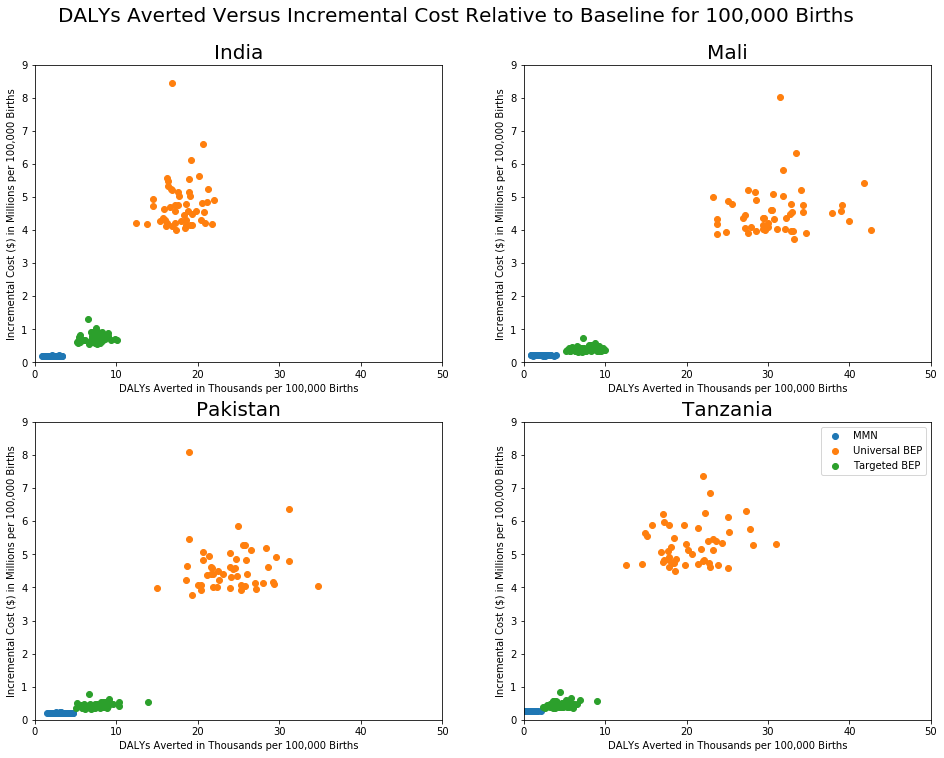

In [16]:
fig, axs = plt.subplots(2,2)

india = master_draws.where(master_draws['location'] == 'India').dropna()
mali = master_draws.where(master_draws['location'] == 'Mali').dropna()
pakistan = master_draws.where(master_draws['location'] == 'Pakistan').dropna()
tanzania = master_draws.where(master_draws['location'] == 'Tanzania').dropna()

axs[0,0].scatter(india['dalys_averted_mmn']*(-1)/1_000,india['cost_averted_mmn']/1_000_000)
axs[0,0].scatter(india['dalys_averted_bep']*(-1)/1_000,india['cost_averted_bep']/1_000_000)
axs[0,0].scatter(india['dalys_averted_bep_targeted']*(-1)/1_000,india['cost_averted_bep_targeted']/1_000_000)
axs[0,0].set_title('India',fontsize=20)
axs[0,0].set_xlim(0,50)
axs[0,0].set_ylim(0,9)

axs[0,1].scatter(mali['dalys_averted_mmn']*(-1)/1_000,mali['cost_averted_mmn']/1_000_000)
axs[0,1].scatter(mali['dalys_averted_bep']*(-1)/1_000,mali['cost_averted_bep']/1_000_000)
axs[0,1].scatter(mali['dalys_averted_bep_targeted']*(-1)/1_000,mali['cost_averted_bep_targeted']/1_000_000)
axs[0,1].set_title('Mali',fontsize=20)
axs[0,1].set_xlim(0,50)
axs[0,1].set_ylim(0,9)

axs[1,0].scatter(pakistan['dalys_averted_mmn']*(-1)/1_000,pakistan['cost_averted_mmn']/1_000_000)
axs[1,0].scatter(pakistan['dalys_averted_bep']*(-1)/1_000,pakistan['cost_averted_bep']/1_000_000)
axs[1,0].scatter(pakistan['dalys_averted_bep_targeted']*(-1)/1_000,pakistan['cost_averted_bep_targeted']/1_000_000)
axs[1,0].set_title('Pakistan',fontsize=20)
axs[1,0].set_xlim(0,50)
axs[1,0].set_ylim(0,9)

axs[1,1].scatter(tanzania['dalys_averted_mmn']*(-1)/1_000,tanzania['cost_averted_mmn']/1_000_000)
axs[1,1].scatter(tanzania['dalys_averted_bep']*(-1)/1_000,tanzania['cost_averted_bep']/1_000_000)
axs[1,1].scatter(tanzania['dalys_averted_bep_targeted']*(-1)/1_000,tanzania['cost_averted_bep_targeted']/1_000_000)
axs[1,1].set_title('Tanzania',fontsize=20)
axs[1,1].set_xlim(0,50)
axs[1,1].set_ylim(0,9)

for ax in axs.flat:
    ax.set(xlabel='DALYs Averted in Thousands per 100,000 Births', ylabel='Incremental Cost ($) in Millions per 100,000 Births')
    #ax.label_outer()

plt.legend(['MMN','Universal BEP','Targeted BEP'])
plt.suptitle('DALYs Averted Versus Incremental Cost Relative to Baseline for 100,000 Births',x=1.1,y=2.6,fontsize=20)
plt.subplots_adjust(right=2.2, top=2.4)


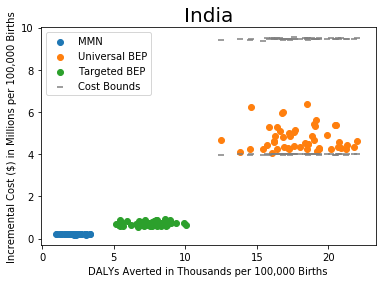

In [23]:
plt.scatter(india['dalys_averted_mmn']*(-1)/1_000,india['cost_averted_mmn']/1_000_000)
plt.scatter(india['dalys_averted_bep']*(-1)/1_000,india['cost_averted_bep']/1_000_000)
plt.scatter(india['dalys_averted_bep_targeted']*(-1)/1_000,india['cost_averted_bep_targeted']/1_000_000)

plt.scatter(india['dalys_averted_bep']*(-1)/1_000,india['cost_averted_bep_low']/1_000_000,marker='_',c='grey')
plt.scatter(india['dalys_averted_bep']*(-1)/1_000,india['cost_averted_bep_high']/1_000_000,marker='_',c='grey')
#plt.scatter(india['dalys_averted_bep_targeted']*(-1)/1_000,india['cost_averted_bep_targeted_low']/1_000_000,marker='_',c='grey')
#plt.scatter(india['dalys_averted_bep_targeted']*(-1)/1_000,india['cost_averted_bep_targeted_high']/1_000_000,marker='_',c='grey')

#plt.yscale('log')
plt.title('India',fontsize=20)
plt.ylabel('Incremental Cost ($) in Millions per 100,000 Births')
plt.xlabel('DALYs Averted in Thousands per 100,000 Births')
plt.legend(['MMN','Universal BEP','Targeted BEP','Cost Bounds'])
plt.savefig('fig_india_ex')

In [15]:
plt.scatter(mali['dalys_averted_mmn']*(-1)/1_000,mali['cost_averted_mmn']/1_000_000)
plt.scatter(mali['dalys_averted_bep']*(-1)/1_000,mali['cost_averted_bep']/1_000_000)
plt.scatter(mali['dalys_averted_bep_targeted']*(-1)/1_000,mali['cost_averted_bep_targeted']/1_000_000)

plt.scatter(mali['dalys_averted_bep']*(-1)/1_000,mali['cost_averted_bep_low']/1_000_000,marker='_',c='grey')
plt.scatter(mali['dalys_averted_bep']*(-1)/1_000,mali['cost_averted_bep_high']/1_000_000,marker='_',c='grey')
#plt.scatter(mali['dalys_averted_bep_targeted']*(-1)/1_000,mali['cost_averted_bep_targeted_low']/1_000_000,marker='_',c='grey')
#plt.scatter(mali['dalys_averted_bep_targeted']*(-1)/1_000,mali['cost_averted_bep_targeted_high']/1_000_000,marker='_',c='grey')

#plt.yscale('log')
plt.title('Mali',fontsize=20)
plt.ylabel('Incremental Cost ($) in Millions per 100,000 Births')
plt.xlabel('DALYs Averted in Thousands per 100,000 Births')
plt.legend(['MMN','Universal BEP','Targeted BEP','Cost Bounds'])
plt.savefig('fig_mali_ex')

NameError: name 'mali' is not defined

In [7]:
plt.scatter(pakistan['dalys_averted_mmn']*(-1)/1_000,pakistan['cost_averted_mmn']/1_000_000)
plt.scatter(pakistan['dalys_averted_bep']*(-1)/1_000,pakistan['cost_averted_bep']/1_000_000)
plt.scatter(pakistan['dalys_averted_bep_targeted']*(-1)/1_000,pakistan['cost_averted_bep_targeted']/1_000_000)

plt.scatter(pakistan['dalys_averted_bep']*(-1)/1_000,pakistan['cost_averted_bep_low']/1_000_000,marker='_',c='grey')
plt.scatter(pakistan['dalys_averted_bep']*(-1)/1_000,pakistan['cost_averted_bep_high']/1_000_000,marker='_',c='grey')
#plt.scatter(pakistan['dalys_averted_bep_targeted']*(-1)/1_000,pakistan['cost_averted_bep_targeted_low']/1_000_000,marker='_',c='grey')
#plt.scatter(pakistan['dalys_averted_bep_targeted']*(-1)/1_000,pakistan['cost_averted_bep_targeted_high']/1_000_000,marker='_',c='grey')

#plt.yscale('log')
plt.title('Pakistan',fontsize=20)
plt.ylabel('Incremental Cost ($) in Millions per 100,000 Births')
plt.xlabel('DALYs Averted in Thousands per 100,000 Births')
plt.legend(['MMN','Universal BEP','Targeted BEP','Cost Bounds'])
plt.savefig('fig_pakistan_ex')

NameError: name 'plt' is not defined

In [8]:
plt.scatter(tanzania['dalys_averted_mmn']*(-1)/1_000,tanzania['cost_averted_mmn']/1_000_000)
plt.scatter(tanzania['dalys_averted_bep']*(-1)/1_000,tanzania['cost_averted_bep']/1_000_000)
plt.scatter(tanzania['dalys_averted_bep_targeted']*(-1)/1_000,tanzania['cost_averted_bep_targeted']/1_000_000)

plt.scatter(tanzania['dalys_averted_bep']*(-1)/1_000,tanzania['cost_averted_bep_low']/1_000_000,marker='_',c='grey')
plt.scatter(tanzania['dalys_averted_bep']*(-1)/1_000,tanzania['cost_averted_bep_high']/1_000_000,marker='_',c='grey')
#plt.scatter(tanzania['dalys_averted_bep_targeted']*(-1)/1_000,tanzania['cost_averted_bep_targeted_low']/1_000_000,marker='_',c='grey')
#plt.scatter(tanzania['dalys_averted_bep_targeted']*(-1)/1_000,tanzania['cost_averted_bep_targeted_high']/1_000_000,marker='_',c='grey')

#plt.yscale('log')
plt.title('Tanzania',fontsize=20)
plt.ylabel('Incremental Cost ($) in Millions per 100,000 Births')
plt.xlabel('DALYs Averted in Thousands per 100,000 Births')
plt.legend(['MMN','Universal BEP','Targeted BEP','Cost Bounds'])
plt.savefig('fig_tanzania_ex')

NameError: name 'plt' is not defined

In [9]:
data = master_avg#.where(master_avg['malnourishment_category'] == 'all').dropna()

# bar width
barWidth = 0.2

# bar heights
baseline = master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna() / 1_000
baseline_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_baseline').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna())/ 1_000
baseline_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_baseline').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_baseline').dropna())/ 1_000

mmn = master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna()/ 1_000
mmn_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_mmn').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna())/ 1_000
mmn_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_mmn').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_mmn').dropna())/ 1_000

bep = master_avg['mean'].where(master_avg['index'] == 'dalys_bep').dropna() /1_000
bep_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_bep').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_bep').dropna())/ 1_000
bep_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_bep').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_bep').dropna())/1_000


bep_targeted = master_avg['mean'].where(master_avg['index'] == 'dalys_bep_targeted').dropna()/1_000
bep_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'dalys_bep_targeted').dropna() -  master_avg['mean'].where(master_avg['index'] == 'dalys_bep_targeted').dropna())/1_000
bep_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'dalys_bep_targeted').dropna() -  master_avg['min'].where(master_avg['index'] == 'dalys_bep_targeted').dropna())/1_000


# bar positions
baseline_x = np.arange(len(baseline)) 
mmn_x = [x + barWidth for x in baseline_x]
bep_x = [x + barWidth for x in mmn_x]
bep_targeted_x = [x + barWidth for x in bep_x]

# plot
plt.bar(baseline_x, baseline, yerr=[baseline_upper, baseline_lower], width=barWidth)
plt.bar(mmn_x, mmn, yerr=[mmn_upper, mmn_lower], width=barWidth)
plt.bar(bep_x, bep, yerr=[bep_upper, bep_lower], width=barWidth)
plt.bar(bep_targeted_x, bep_targeted, yerr=[bep_targeted_upper, bep_targeted_lower], width=barWidth)

#
plt.xticks([r + barWidth for r in range(len(baseline))], master_avg['location'].where(master_avg['index'] == 'dalys_baseline').dropna())
plt.ylabel('DALYs (thousands) per 100,000 Births')
plt.title('DALYs in Thousands per 100,000 Births')
plt.legend(['Baseline','MMN','Universal BEP','Targeted BEP'])
plt.savefig('fig_DALYS')

NameError: name 'master_avg' is not defined

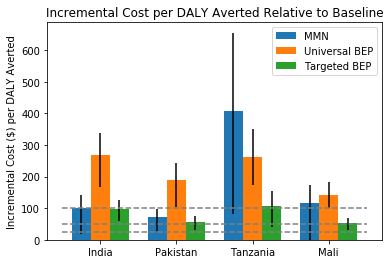

In [24]:
data = master_avg#.where(master_avg['malnourishment_category'] == 'all').dropna()*(-1)

# bar width
barWidth = 0.25

# bar heights
mmn = master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)
mmn_upper =  master_avg['max'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)
mmn_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)

bep = master_avg['mean'].where(master_avg['index'] == 'icer_bep').dropna()*(-1)
bep_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1))
bep_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1))

bep_targeted = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted').dropna()*(-1)
bep_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1))
bep_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1))

#bep_low = master_avg['mean'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1)
#bep_low_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1)
#bep_low_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1)

#bep_targeted_high = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1)
#bep_targeted_high_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1)
#bep_targeted_high_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1)

# bar positions
mmn_x = np.arange(len(mmn)) 
bep_x = [x + barWidth for x in mmn_x]
bep_targeted_x = [x + barWidth for x in bep_x]

# plot
plt.bar(mmn_x, mmn,width=barWidth, yerr=[mmn_upper, mmn_lower])
plt.bar(bep_x, bep, yerr=[bep_upper, bep_lower], width=barWidth)
plt.bar(bep_targeted_x, bep_targeted, yerr=[bep_targeted_upper, bep_targeted_lower], width=barWidth)
plt.legend(['MMN','Universal BEP','Targeted BEP','Willingness to Pay Threshold'])
threshold = 100
threshold2 = 50
threshold3 = 25
plt.plot([-0.25,len(mmn)-.25], [threshold, threshold],'k--', c='gray')
plt.plot([-0.25,len(mmn)-.25], [threshold2, threshold2],'k--', c='gray')
plt.plot([-0.25,len(mmn)-.25], [threshold3, threshold3],'k--', c='gray')

#
plt.xticks([r + barWidth for r in range(len(mmn))], master_avg['location'].where(master_avg['index'] == 'icer_mmn').dropna())
plt.ylabel('Incremental Cost ($) per DALY Averted')
plt.title('Incremental Cost per DALY Averted Relative to Baseline')
plt.savefig('fig_ICERS_baseline')

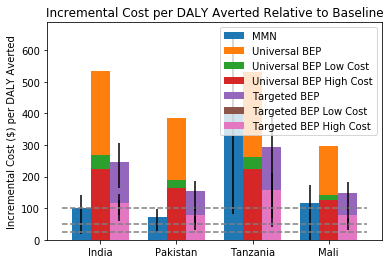

In [25]:
data = master_avg#.where(master_avg['malnourishment_category'] == 'all').dropna()*(-1)

# bar width
barWidth = 0.25

# bar heights
mmn = master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)
mmn_upper =  master_avg['max'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)
mmn_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_mmn').dropna()*(-1)

bep = master_avg['mean'].where(master_avg['index'] == 'icer_bep').dropna()*(-1)
bep_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1))
bep_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep').dropna().values*(-1))

bep_low = master_avg['mean'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1)
bep_low_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1)
bep_low_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_low').dropna()*(-1)

bep_high = master_avg['mean'].where(master_avg['index'] == 'icer_bep_high').dropna()*(-1)
bep_high_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_high').dropna()*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_high').dropna()*(-1)
bep_high_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_high').dropna()*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_high').dropna()*(-1)

bep_targeted_high = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1)
bep_targeted_high_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1)
bep_targeted_high_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted_high').dropna()*(-1)

bep_targeted = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted').dropna()*(-1)
bep_targeted_upper =  (master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1))
bep_targeted_lower =  (master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted').dropna().values*(-1))

bep_targeted_low = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_low').dropna()*(-1)
bep_targeted_low_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted_low').dropna()*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_low').dropna()*(-1)
bep_targeted_low_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_low').dropna()*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted_low').dropna()*(-1)

bep_targeted_targeted_high = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_targeted_high').dropna()*(-1)
bep_targeted_targeted_high_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted_targeted_high').dropna()*(-1) -  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_targeted_high').dropna()*(-1)
bep_targeted_targeted_high_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_targeted_high').dropna()*(-1) -  master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted_targeted_high').dropna()*(-1)


# bar positions
mmn_x = np.arange(len(mmn)) 
bep_x = [x + barWidth for x in mmn_x]
bep_targeted_x = [x + barWidth for x in bep_x]
#bep_high_x = [x + barWidth for x in bep_low_x]
#bep_targeted_x = [x + barWidth for x in bep_high_x]
#bep_targeted_low_x = [x + barWidth for x in bep_targeted_x]
#bep_targeted_high_x = [x + barWidth for x in bep_targeted_low_x]


# plot
plt.bar(mmn_x, mmn,width=barWidth, yerr=[mmn_upper, mmn_lower])

plt.bar(bep_x, bep_high, width=barWidth) #yerr=[bep_high_upper, bep_high_lower],
plt.bar(bep_x, bep,  width=barWidth) #yerr=[bep_upper, bep_lower],
plt.bar(bep_x, bep_low, width=barWidth)

plt.bar(bep_targeted_x, bep_targeted_high, yerr=[bep_targeted_high_upper, bep_targeted_high_lower], width=barWidth)
plt.bar(bep_targeted_x, bep_targeted, yerr=[bep_targeted_upper, bep_targeted_lower], width=barWidth)
plt.bar(bep_targeted_x, bep_targeted_low, yerr=[bep_targeted_low_upper, bep_targeted_low_lower], width=barWidth)

plt.legend(['MMN','Universal BEP','Universal BEP Low Cost','Universal BEP High Cost',
           'Targeted BEP','Targeted BEP Low Cost','Targeted BEP High Cost'])
threshold = 100
threshold2 = 50
threshold3 = 25
plt.plot([-0.25,len(mmn)-.25], [threshold, threshold],'k--', c='gray')
plt.plot([-0.25,len(mmn)-.25], [threshold2, threshold2],'k--', c='gray')
plt.plot([-0.25,len(mmn)-.25], [threshold3, threshold3],'k--', c='gray')

#
plt.xticks([r + barWidth for r in range(len(mmn))], master_avg['location'].where(master_avg['index'] == 'icer_mmn').dropna())
plt.ylabel('Incremental Cost ($) per DALY Averted')
plt.title('Incremental Cost per DALY Averted Relative to Baseline')
plt.savefig('fig_ICERS_baseline')

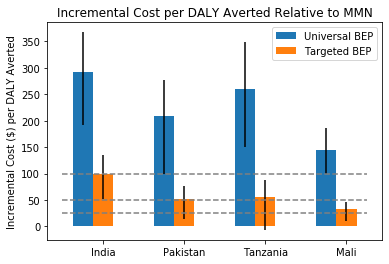

In [27]:
data = master_avg#.where(master_avg['malnourishment_category'] == 'all').dropna()*(-1)

# bar width
barWidth = 0.25

# bar heights
bep = master_avg['mean'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1)
bep_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1)
bep_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_bep_rel_to_mmn').dropna()*(-1)

bep_targeted = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1)
bep_targeted_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1)
bep_targeted_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_mmn').dropna()*(-1)

# bar positions
bep_x = np.arange(len(bep)) 
bep_targeted_x = [x + barWidth for x in bep_x]

# plot
plt.bar(bep_x, bep, yerr=[bep_upper, bep_lower], width=barWidth)
plt.bar(bep_targeted_x, bep_targeted, yerr=[bep_targeted_upper, bep_targeted_lower], width=barWidth)

#
plt.xticks([r + barWidth for r in range(len(bep))], master_avg['location'].where(master_avg['index'] == 'icer_mmn').dropna())
plt.ylabel('Incremental Cost ($) per DALY Averted')
plt.title('Incremental Cost per DALY Averted Relative to MMN')
plt.legend(['Universal BEP','Targeted BEP'])

threshold = 100
threshold2 = 50
threshold3 = 25
plt.plot([-0.25,len(mmn)-0.5], [threshold, threshold],'k--', c='gray')
plt.plot([-0.25,len(mmn)-0.5], [threshold2, threshold2],'k--', c='gray')
plt.plot([-0.25,len(mmn)-0.5], [threshold3, threshold3],'k--', c='gray')
plt.savefig('fig_ICERS_mmn')

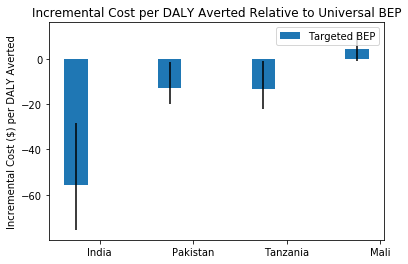

In [26]:
data = master_avg#.where(master_avg['malnourishment_category'] == 'all').dropna()*(-1)

# bar width
barWidth = 0.25

# bar heights
bep_targeted = master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_bep').dropna()*(-1)
bep_targeted_upper =  master_avg['max'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_bep').dropna()*(-1) - master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_bep').dropna()*(-1)
bep_targeted_lower =  master_avg['mean'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_bep').dropna()*(-1) - master_avg['min'].where(master_avg['index'] == 'icer_bep_targeted_rel_to_bep').dropna()*(-1)

# bar positions
bep_targeted_x = np.arange(len(bep_targeted)) 

# plot
plt.bar(bep_targeted_x, bep_targeted, yerr=[bep_targeted_upper, bep_targeted_lower], width=barWidth)

#
plt.xticks([r + barWidth for r in range(len(bep_targeted))], master_avg['location'].where(master_avg['index'] == 'icer_mmn').dropna())
plt.ylabel('Incremental Cost ($) per DALY Averted')
plt.title('Incremental Cost per DALY Averted Relative to Universal BEP')
plt.legend(['Targeted BEP'])

In [14]:
fig, axs = plt.subplots(2,2)

india = master_draws.where(master_draws['location'] == 'India').dropna()
#mali = master_draws.where(master_draws['location'] == 'Mali').dropna()
pakistan = master_draws.where(master_draws['location'] == 'Pakistan').dropna()
tanzania = master_draws.where(master_draws['location'] == 'Tanzania').dropna()

axs[0,0].scatter(india['dalys_baseline']/1_000,india['cost_baseline']/1_000_000)
axs[0,0].scatter(india['dalys_mmn']/1_000,india['cost_mmn']/1_000_000)
axs[0,0].scatter(india['dalys_bep']/1_000,india['cost_bep']/1_000_000)
axs[0,0].scatter(india['dalys_bep_targeted']/1_000,india['cost_bep_targeted']/1_000_000)
#axs[0,0].legend(['Baseline','MMN','BEP','MMN/Targeted BEP'])
axs[0,0].set_title('India',fontsize=20)

#axs[0,1].scatter(mali['dalys_baseline']/1_000,mali['cost_baseline']/1_000_000)
#axs[0,1].scatter(mali['dalys_mmn']/1_000,mali['cost_mmn']/1_000_000)
#axs[0,1].scatter(mali['dalys_bep']/1_000,mali['cost_bep']/1_000_000)
#axs[0,1].scatter(mali['dalys_bep_tageted']/1_000,mali['cost_bep_targeted']/1_000_000)
#axs[0,1].set_title('Mali',fontsize=20)

axs[1,0].scatter(pakistan['dalys_baseline']/1_000,pakistan['cost_baseline']/1_000_000)
axs[1,0].scatter(pakistan['dalys_mmn']/1_000,pakistan['cost_mmn']/1_000_000)
axs[1,0].scatter(pakistan['dalys_bep']/1_000,pakistan['cost_bep']/1_000_000)
axs[1,0].scatter(pakistan['dalys_bep_targeted']/1_000,pakistan['cost_bep_targeted']/1_000_000)
axs[1,0].set_title('Pakistan',fontsize=20)

axs[1,1].scatter(tanzania['dalys_baseline']/1_000,tanzania['cost_baseline']/1_000_000)
axs[1,1].scatter(tanzania['dalys_mmn']/1_000,tanzania['cost_mmn']/1_000_000)
axs[1,1].scatter(tanzania['dalys_bep']/1_000,tanzania['cost_bep']/1_000_000)
axs[1,1].scatter(tanzania['dalys_bep_targeted']/1_000,tanzania['cost_bep_targeted']/1_000_000)
axs[1,1].set_title('Tanzania',fontsize=20)

for ax in axs.flat:
    ax.set(xlabel='DALYs in Thousands per 100,000 Births', ylabel='Cost ($) in Millions per 100,000 Births')
    #ax.label_outer()

plt.legend(['Baseline','MMN','BEP','MMN/Targeted BEP'])
plt.suptitle('DALYs Versus Cost',x=0.75,y=2.5,fontsize=20)
plt.subplots_adjust(right=1.5, top=2.3)

NameError: name 'plt' is not defined